# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.7967
Epoch 1/200, Iteration 2/12, Loss: 0.4743
Epoch 1/200, Iteration 3/12, Loss: 0.2322
Epoch 1/200, Iteration 4/12, Loss: 0.2635
Epoch 1/200, Iteration 5/12, Loss: 0.3681
Epoch 1/200, Iteration 6/12, Loss: 0.4016
Epoch 1/200, Iteration 7/12, Loss: 0.3732
Epoch 1/200, Iteration 8/12, Loss: 0.3023
Epoch 1/200, Iteration 9/12, Loss: 0.2346
Epoch 1/200, Iteration 10/12, Loss: 0.2552
Epoch 1/200, Iteration 11/12, Loss: 0.3021
Epoch 1/200, Iteration 12/12, Loss: 0.2541
Epoch 1/200, Iteration 13/12, Loss: 0.3020
Train Error: 
 Accuracy: 75.25%, Avg loss: 0.270425, MRE: 0.222887, MAE: 0.030729 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.248029, MRE: 0.166874, MAE: 0.027252 

Epoch 2/200, Iteration 1/12, Loss: 0.2801
Epoch 2/200, Iteration 2/12, Loss: 0.2631
Epoch 2/200, Iteration 3/12, Loss: 0.2569
Epoch 2/200, Iteration 4/12, Loss: 0.2823
Epoch 2/200, Iteration 5/12, Loss: 0.3261
Epoch 2/200, Iteration 6/12, Loss: 0.1921
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 91.25%, Avg loss: 0.061130, MRE: 0.042448, MAE: 0.007557 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.055394, MRE: 0.037132, MAE: 0.006785 

Epoch 13/200, Iteration 1/12, Loss: 0.0713
Epoch 13/200, Iteration 2/12, Loss: 0.0675
Epoch 13/200, Iteration 3/12, Loss: 0.0769
Epoch 13/200, Iteration 4/12, Loss: 0.0597
Epoch 13/200, Iteration 5/12, Loss: 0.0679
Epoch 13/200, Iteration 6/12, Loss: 0.0689
Epoch 13/200, Iteration 7/12, Loss: 0.0833
Epoch 13/200, Iteration 8/12, Loss: 0.0760
Epoch 13/200, Iteration 9/12, Loss: 0.0828
Epoch 13/200, Iteration 10/12, Loss: 0.0752
Epoch 13/200, Iteration 11/12, Loss: 0.0753
Epoch 13/200, Iteration 12/12, Loss: 0.0553
Epoch 13/200, Iteration 13/12, Loss: 0.0601
Train Error: 
 Accuracy: 82.62%, Avg loss: 0.080177, MRE: 0.069303, MAE: 0.009904 

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.070313, MRE: 0.056979, MAE: 0.008287 

Epoch 14/200, Iteration 1/12, Loss: 0.0860
Epoch 14/200, Iteration 2/12, Loss: 0.0609
Epoch 14/200, Itera

Train Error: 
 Accuracy: 95.88%, Avg loss: 0.042559, MRE: 0.030476, MAE: 0.005308 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.036529, MRE: 0.024421, MAE: 0.004565 

Epoch 25/200, Iteration 1/12, Loss: 0.0367
Epoch 25/200, Iteration 2/12, Loss: 0.0342
Epoch 25/200, Iteration 3/12, Loss: 0.0592
Epoch 25/200, Iteration 4/12, Loss: 0.0431
Epoch 25/200, Iteration 5/12, Loss: 0.0490
Epoch 25/200, Iteration 6/12, Loss: 0.0484
Epoch 25/200, Iteration 7/12, Loss: 0.0319
Epoch 25/200, Iteration 8/12, Loss: 0.0400
Epoch 25/200, Iteration 9/12, Loss: 0.0338
Epoch 25/200, Iteration 10/12, Loss: 0.0432
Epoch 25/200, Iteration 11/12, Loss: 0.0473
Epoch 25/200, Iteration 12/12, Loss: 0.0503
Epoch 25/200, Iteration 13/12, Loss: 0.0468
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.039952, MRE: 0.027588, MAE: 0.004804 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.034166, MRE: 0.023378, MAE: 0.004112 

Epoch 26/200, Iteration 1/12, Loss: 0.0273
Epoch 26/200, Iteration 2/12, Loss: 0.0612
Epoch 26/200, Iterat

Epoch 36/200, Iteration 7/12, Loss: 0.0304
Epoch 36/200, Iteration 8/12, Loss: 0.0289
Epoch 36/200, Iteration 9/12, Loss: 0.0480
Epoch 36/200, Iteration 10/12, Loss: 0.0291
Epoch 36/200, Iteration 11/12, Loss: 0.0378
Epoch 36/200, Iteration 12/12, Loss: 0.0414
Epoch 36/200, Iteration 13/12, Loss: 0.0640
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.038563, MRE: 0.026379, MAE: 0.004686 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.033396, MRE: 0.021814, MAE: 0.004084 

Epoch 37/200, Iteration 1/12, Loss: 0.0404
Epoch 37/200, Iteration 2/12, Loss: 0.0343
Epoch 37/200, Iteration 3/12, Loss: 0.0446
Epoch 37/200, Iteration 4/12, Loss: 0.0411
Epoch 37/200, Iteration 5/12, Loss: 0.0455
Epoch 37/200, Iteration 6/12, Loss: 0.0301
Epoch 37/200, Iteration 7/12, Loss: 0.0312
Epoch 37/200, Iteration 8/12, Loss: 0.0355
Epoch 37/200, Iteration 9/12, Loss: 0.0277
Epoch 37/200, Iteration 10/12, Loss: 0.0477
Epoch 37/200, Iteration 11/12, Loss: 0.0458
Epoch 37/200, Iteration 12/12, Loss: 0.0412
Epoch 37/2

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.036377, MRE: 0.024079, MAE: 0.004458 

Epoch 48/200, Iteration 1/12, Loss: 0.0347
Epoch 48/200, Iteration 2/12, Loss: 0.0424
Epoch 48/200, Iteration 3/12, Loss: 0.0287
Epoch 48/200, Iteration 4/12, Loss: 0.0274
Epoch 48/200, Iteration 5/12, Loss: 0.0423
Epoch 48/200, Iteration 6/12, Loss: 0.0290
Epoch 48/200, Iteration 7/12, Loss: 0.0595
Epoch 48/200, Iteration 8/12, Loss: 0.0346
Epoch 48/200, Iteration 9/12, Loss: 0.0320
Epoch 48/200, Iteration 10/12, Loss: 0.0361
Epoch 48/200, Iteration 11/12, Loss: 0.0374
Epoch 48/200, Iteration 12/12, Loss: 0.0449
Epoch 48/200, Iteration 13/12, Loss: 0.0470
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.036539, MRE: 0.026626, MAE: 0.004333 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.030912, MRE: 0.021954, MAE: 0.003690 

Epoch 49/200, Iteration 1/12, Loss: 0.0361
Epoch 49/200, Iteration 2/12, Loss: 0.0377
Epoch 49/200, Iteration 3/12, Loss: 0.0252
Epoch 49/200, Iteration 4/12, Loss: 0.0381
Epoch 49/200, Ite

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.030078, MRE: 0.019987, MAE: 0.003600 

Epoch 60/200, Iteration 1/12, Loss: 0.0355
Epoch 60/200, Iteration 2/12, Loss: 0.0230
Epoch 60/200, Iteration 3/12, Loss: 0.0340
Epoch 60/200, Iteration 4/12, Loss: 0.0279
Epoch 60/200, Iteration 5/12, Loss: 0.0486
Epoch 60/200, Iteration 6/12, Loss: 0.0305
Epoch 60/200, Iteration 7/12, Loss: 0.0215
Epoch 60/200, Iteration 8/12, Loss: 0.0275
Epoch 60/200, Iteration 9/12, Loss: 0.0523
Epoch 60/200, Iteration 10/12, Loss: 0.0352
Epoch 60/200, Iteration 11/12, Loss: 0.0363
Epoch 60/200, Iteration 12/12, Loss: 0.0420
Epoch 60/200, Iteration 13/12, Loss: 0.0345
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034561, MRE: 0.024199, MAE: 0.004118 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029648, MRE: 0.019725, MAE: 0.003555 

Epoch 61/200, Iteration 1/12, Loss: 0.0262
Epoch 61/200, Iteration 2/12, Loss: 0.0321
Epoch 61/200, Iteration 3/12, Loss: 0.0387
Epoch 61/200, Iteration 4/12, Loss: 0.0298
Epoch 61/200, Ite

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034685, MRE: 0.025195, MAE: 0.004148 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029731, MRE: 0.019720, MAE: 0.003562 

Epoch 72/200, Iteration 1/12, Loss: 0.0304
Epoch 72/200, Iteration 2/12, Loss: 0.0333
Epoch 72/200, Iteration 3/12, Loss: 0.0314
Epoch 72/200, Iteration 4/12, Loss: 0.0579
Epoch 72/200, Iteration 5/12, Loss: 0.0329
Epoch 72/200, Iteration 6/12, Loss: 0.0433
Epoch 72/200, Iteration 7/12, Loss: 0.0280
Epoch 72/200, Iteration 8/12, Loss: 0.0331
Epoch 72/200, Iteration 9/12, Loss: 0.0331
Epoch 72/200, Iteration 10/12, Loss: 0.0381
Epoch 72/200, Iteration 11/12, Loss: 0.0295
Epoch 72/200, Iteration 12/12, Loss: 0.0274
Epoch 72/200, Iteration 13/12, Loss: 0.0187
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033808, MRE: 0.024111, MAE: 0.004045 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029705, MRE: 0.019734, MAE: 0.003558 

Epoch 73/200, Iteration 1/12, Loss: 0.0214
Epoch 73/200, Iteration 2/12, Loss: 0.0445
Epoch 73/200, Itera

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034119, MRE: 0.024433, MAE: 0.004082 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029677, MRE: 0.019735, MAE: 0.003554 

Epoch 84/200, Iteration 1/12, Loss: 0.0318
Epoch 84/200, Iteration 2/12, Loss: 0.0256
Epoch 84/200, Iteration 3/12, Loss: 0.0465
Epoch 84/200, Iteration 4/12, Loss: 0.0321
Epoch 84/200, Iteration 5/12, Loss: 0.0512
Epoch 84/200, Iteration 6/12, Loss: 0.0327
Epoch 84/200, Iteration 7/12, Loss: 0.0394
Epoch 84/200, Iteration 8/12, Loss: 0.0301
Epoch 84/200, Iteration 9/12, Loss: 0.0324
Epoch 84/200, Iteration 10/12, Loss: 0.0230
Epoch 84/200, Iteration 11/12, Loss: 0.0402
Epoch 84/200, Iteration 12/12, Loss: 0.0294
Epoch 84/200, Iteration 13/12, Loss: 0.0259
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034745, MRE: 0.024284, MAE: 0.004144 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029676, MRE: 0.019734, MAE: 0.003554 

Epoch 85/200, Iteration 1/12, Loss: 0.0433
Epoch 85/200, Iteration 2/12, Loss: 0.0237
Epoch 85/200, Itera

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034019, MRE: 0.024091, MAE: 0.004065 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029664, MRE: 0.019731, MAE: 0.003553 

Epoch 96/200, Iteration 1/12, Loss: 0.0426
Epoch 96/200, Iteration 2/12, Loss: 0.0218
Epoch 96/200, Iteration 3/12, Loss: 0.0366
Epoch 96/200, Iteration 4/12, Loss: 0.0360
Epoch 96/200, Iteration 5/12, Loss: 0.0273
Epoch 96/200, Iteration 6/12, Loss: 0.0389
Epoch 96/200, Iteration 7/12, Loss: 0.0372
Epoch 96/200, Iteration 8/12, Loss: 0.0335
Epoch 96/200, Iteration 9/12, Loss: 0.0282
Epoch 96/200, Iteration 10/12, Loss: 0.0291
Epoch 96/200, Iteration 11/12, Loss: 0.0428
Epoch 96/200, Iteration 12/12, Loss: 0.0305
Epoch 96/200, Iteration 13/12, Loss: 0.0455
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033938, MRE: 0.024276, MAE: 0.004060 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029668, MRE: 0.019734, MAE: 0.003554 

Epoch 97/200, Iteration 1/12, Loss: 0.0306
Epoch 97/200, Iteration 2/12, Loss: 0.0297
Epoch 97/200, Itera

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034559, MRE: 0.024290, MAE: 0.004121 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029673, MRE: 0.019734, MAE: 0.003555 

Epoch 108/200, Iteration 1/12, Loss: 0.0227
Epoch 108/200, Iteration 2/12, Loss: 0.0211
Epoch 108/200, Iteration 3/12, Loss: 0.0208
Epoch 108/200, Iteration 4/12, Loss: 0.0618
Epoch 108/200, Iteration 5/12, Loss: 0.0303
Epoch 108/200, Iteration 6/12, Loss: 0.0532
Epoch 108/200, Iteration 7/12, Loss: 0.0329
Epoch 108/200, Iteration 8/12, Loss: 0.0336
Epoch 108/200, Iteration 9/12, Loss: 0.0444
Epoch 108/200, Iteration 10/12, Loss: 0.0262
Epoch 108/200, Iteration 11/12, Loss: 0.0343
Epoch 108/200, Iteration 12/12, Loss: 0.0297
Epoch 108/200, Iteration 13/12, Loss: 0.0327
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033917, MRE: 0.024099, MAE: 0.004057 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029673, MRE: 0.019734, MAE: 0.003555 

Epoch 109/200, Iteration 1/12, Loss: 0.0609
Epoch 109/200, Iteration 2/12, Loss: 0.0362
Epoc

Epoch 119/200, Iteration 3/12, Loss: 0.0240
Epoch 119/200, Iteration 4/12, Loss: 0.0374
Epoch 119/200, Iteration 5/12, Loss: 0.0310
Epoch 119/200, Iteration 6/12, Loss: 0.0207
Epoch 119/200, Iteration 7/12, Loss: 0.0356
Epoch 119/200, Iteration 8/12, Loss: 0.0301
Epoch 119/200, Iteration 9/12, Loss: 0.0413
Epoch 119/200, Iteration 10/12, Loss: 0.0434
Epoch 119/200, Iteration 11/12, Loss: 0.0301
Epoch 119/200, Iteration 12/12, Loss: 0.0346
Epoch 119/200, Iteration 13/12, Loss: 0.0499
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033594, MRE: 0.024070, MAE: 0.004029 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029673, MRE: 0.019734, MAE: 0.003555 

Epoch 120/200, Iteration 1/12, Loss: 0.0287
Epoch 120/200, Iteration 2/12, Loss: 0.0309
Epoch 120/200, Iteration 3/12, Loss: 0.0283
Epoch 120/200, Iteration 4/12, Loss: 0.0467
Epoch 120/200, Iteration 5/12, Loss: 0.0343
Epoch 120/200, Iteration 6/12, Loss: 0.0317
Epoch 120/200, Iteration 7/12, Loss: 0.0440
Epoch 120/200, Iteration 8/12, Loss: 0

Epoch 131/200, Iteration 1/12, Loss: 0.0415
Epoch 131/200, Iteration 2/12, Loss: 0.0331
Epoch 131/200, Iteration 3/12, Loss: 0.0217
Epoch 131/200, Iteration 4/12, Loss: 0.0407
Epoch 131/200, Iteration 5/12, Loss: 0.0443
Epoch 131/200, Iteration 6/12, Loss: 0.0421
Epoch 131/200, Iteration 7/12, Loss: 0.0222
Epoch 131/200, Iteration 8/12, Loss: 0.0339
Epoch 131/200, Iteration 9/12, Loss: 0.0224
Epoch 131/200, Iteration 10/12, Loss: 0.0365
Epoch 131/200, Iteration 11/12, Loss: 0.0313
Epoch 131/200, Iteration 12/12, Loss: 0.0499
Epoch 131/200, Iteration 13/12, Loss: 0.0154
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033837, MRE: 0.023946, MAE: 0.004043 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019734, MAE: 0.003555 

Epoch 132/200, Iteration 1/12, Loss: 0.0410
Epoch 132/200, Iteration 2/12, Loss: 0.0280
Epoch 132/200, Iteration 3/12, Loss: 0.0398
Epoch 132/200, Iteration 4/12, Loss: 0.0314
Epoch 132/200, Iteration 5/12, Loss: 0.0418
Epoch 132/200, Iteration 6/12, Loss: 0

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033651, MRE: 0.023949, MAE: 0.004024 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019734, MAE: 0.003555 

Epoch 143/200, Iteration 1/12, Loss: 0.0344
Epoch 143/200, Iteration 2/12, Loss: 0.0286
Epoch 143/200, Iteration 3/12, Loss: 0.0277
Epoch 143/200, Iteration 4/12, Loss: 0.0373
Epoch 143/200, Iteration 5/12, Loss: 0.0390
Epoch 143/200, Iteration 6/12, Loss: 0.0395
Epoch 143/200, Iteration 7/12, Loss: 0.0290
Epoch 143/200, Iteration 8/12, Loss: 0.0575
Epoch 143/200, Iteration 9/12, Loss: 0.0299
Epoch 143/200, Iteration 10/12, Loss: 0.0324
Epoch 143/200, Iteration 11/12, Loss: 0.0334
Epoch 143/200, Iteration 12/12, Loss: 0.0218
Epoch 143/200, Iteration 13/12, Loss: 0.0340
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033772, MRE: 0.026479, MAE: 0.004051 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019734, MAE: 0.003554 

Epoch 144/200, Iteration 1/12, Loss: 0.0269
Epoch 144/200, Iteration 2/12, Loss: 0.0725
Epoc

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019734, MAE: 0.003554 

Epoch 155/200, Iteration 1/12, Loss: 0.0287
Epoch 155/200, Iteration 2/12, Loss: 0.0375
Epoch 155/200, Iteration 3/12, Loss: 0.0289
Epoch 155/200, Iteration 4/12, Loss: 0.0373
Epoch 155/200, Iteration 5/12, Loss: 0.0258
Epoch 155/200, Iteration 6/12, Loss: 0.0323
Epoch 155/200, Iteration 7/12, Loss: 0.0231
Epoch 155/200, Iteration 8/12, Loss: 0.0272
Epoch 155/200, Iteration 9/12, Loss: 0.0509
Epoch 155/200, Iteration 10/12, Loss: 0.0384
Epoch 155/200, Iteration 11/12, Loss: 0.0398
Epoch 155/200, Iteration 12/12, Loss: 0.0364
Epoch 155/200, Iteration 13/12, Loss: 0.0419
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034103, MRE: 0.024216, MAE: 0.004076 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019734, MAE: 0.003554 

Epoch 156/200, Iteration 1/12, Loss: 0.0295
Epoch 156/200, Iteration 2/12, Loss: 0.0290
Epoch 156/200, Iteration 3/12, Loss: 0.0339
Epoch 156/200, Iteration 4/12, Loss: 0.0384


Epoch 166/200, Iteration 13/12, Loss: 0.0261
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033886, MRE: 0.024074, MAE: 0.004049 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019734, MAE: 0.003554 

Epoch 167/200, Iteration 1/12, Loss: 0.0283
Epoch 167/200, Iteration 2/12, Loss: 0.0319
Epoch 167/200, Iteration 3/12, Loss: 0.0267
Epoch 167/200, Iteration 4/12, Loss: 0.0463
Epoch 167/200, Iteration 5/12, Loss: 0.0251
Epoch 167/200, Iteration 6/12, Loss: 0.0370
Epoch 167/200, Iteration 7/12, Loss: 0.0316
Epoch 167/200, Iteration 8/12, Loss: 0.0480
Epoch 167/200, Iteration 9/12, Loss: 0.0332
Epoch 167/200, Iteration 10/12, Loss: 0.0280
Epoch 167/200, Iteration 11/12, Loss: 0.0284
Epoch 167/200, Iteration 12/12, Loss: 0.0427
Epoch 167/200, Iteration 13/12, Loss: 0.0406
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034697, MRE: 0.024564, MAE: 0.004137 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019734, MAE: 0.003554 

Epoch 168/200, Iteration 1/12, Loss: 0.0290
Epo

Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033606, MRE: 0.023962, MAE: 0.004018 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019733, MAE: 0.003554 

Epoch 178/200, Iteration 1/12, Loss: 0.0328
Epoch 178/200, Iteration 2/12, Loss: 0.0284
Epoch 178/200, Iteration 3/12, Loss: 0.0304
Epoch 178/200, Iteration 4/12, Loss: 0.0335
Epoch 178/200, Iteration 5/12, Loss: 0.0551
Epoch 178/200, Iteration 6/12, Loss: 0.0390
Epoch 178/200, Iteration 7/12, Loss: 0.0336
Epoch 178/200, Iteration 8/12, Loss: 0.0384
Epoch 178/200, Iteration 9/12, Loss: 0.0308
Epoch 178/200, Iteration 10/12, Loss: 0.0261
Epoch 178/200, Iteration 11/12, Loss: 0.0270
Epoch 178/200, Iteration 12/12, Loss: 0.0431
Epoch 178/200, Iteration 13/12, Loss: 0.0185
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.034275, MRE: 0.024384, MAE: 0.004094 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019733, MAE: 0.003554 

Epoch 179/200, Iteration 1/12, Loss: 0.0354
Epoch 179/200, Iteration 2/12, Loss: 0.0309
Epoc

Epoch 189/200, Iteration 3/12, Loss: 0.0351
Epoch 189/200, Iteration 4/12, Loss: 0.0311
Epoch 189/200, Iteration 5/12, Loss: 0.0403
Epoch 189/200, Iteration 6/12, Loss: 0.0283
Epoch 189/200, Iteration 7/12, Loss: 0.0280
Epoch 189/200, Iteration 8/12, Loss: 0.0288
Epoch 189/200, Iteration 9/12, Loss: 0.0434
Epoch 189/200, Iteration 10/12, Loss: 0.0198
Epoch 189/200, Iteration 11/12, Loss: 0.0282
Epoch 189/200, Iteration 12/12, Loss: 0.0393
Epoch 189/200, Iteration 13/12, Loss: 0.0547
Train Error: 
 Accuracy: 96.12%, Avg loss: 0.033756, MRE: 0.023860, MAE: 0.004040 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019733, MAE: 0.003554 

Epoch 190/200, Iteration 1/12, Loss: 0.0292
Epoch 190/200, Iteration 2/12, Loss: 0.0342
Epoch 190/200, Iteration 3/12, Loss: 0.0349
Epoch 190/200, Iteration 4/12, Loss: 0.0472
Epoch 190/200, Iteration 5/12, Loss: 0.0384
Epoch 190/200, Iteration 6/12, Loss: 0.0324
Epoch 190/200, Iteration 7/12, Loss: 0.0329
Epoch 190/200, Iteration 8/12, Loss: 0

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.029672, MRE: 0.019733, MAE: 0.003554 



#### Plots loss vs Epoch

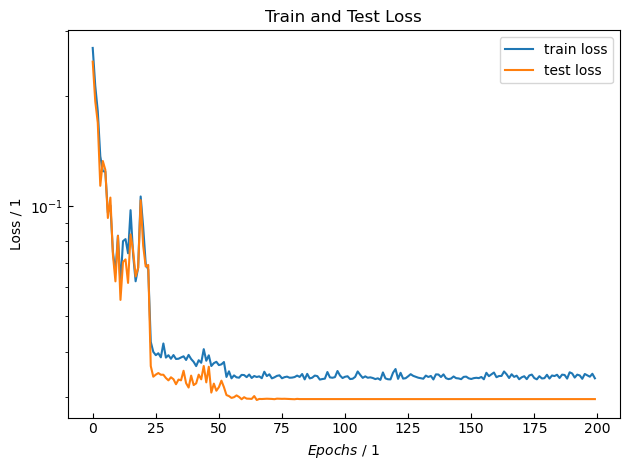

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9979849016426026 , R^2(NH3) = 0.9866495959664421
Test Dataset: R^2(H2) = 0.9989561129027326 , R^2(NH3) = 0.9950617471674242
Max Error Training: |x_H2 - x_H2,pred| = 0.07003072853203685 , |x_NH3 - x_NH3,pred| = 0.11238814597297389
Max Error Test: |x_H2 - x_H2,pred| = 0.02486442537782374 , |x_NH3 - x_NH3,pred| = 0.03744867501788662


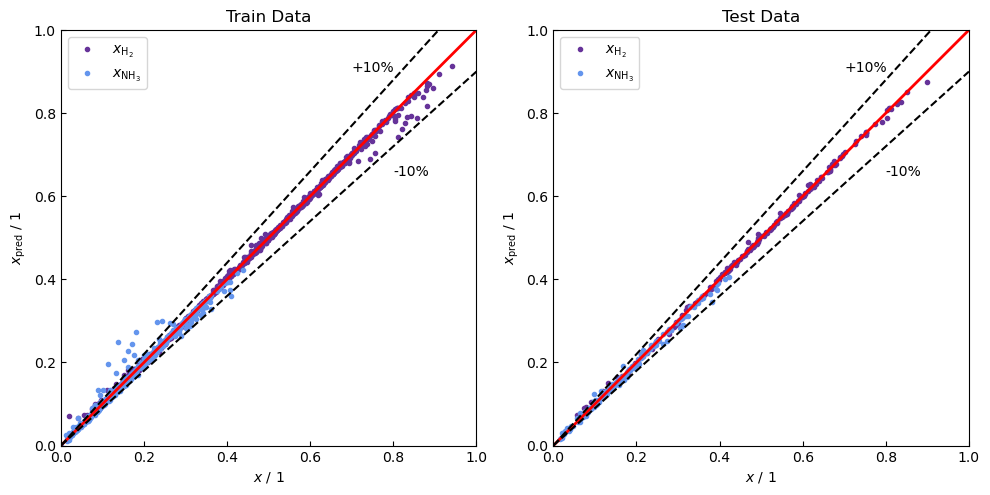

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

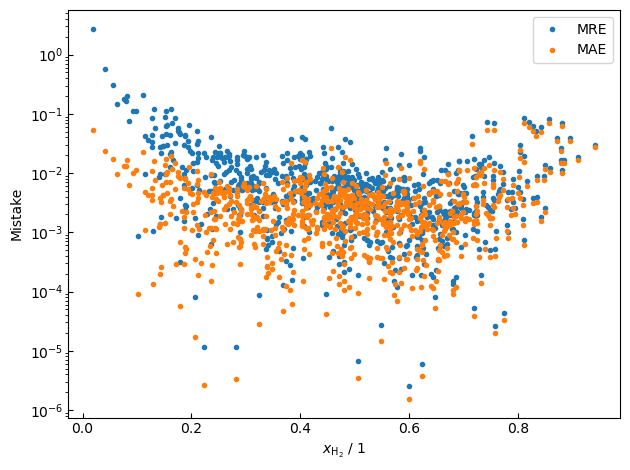

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

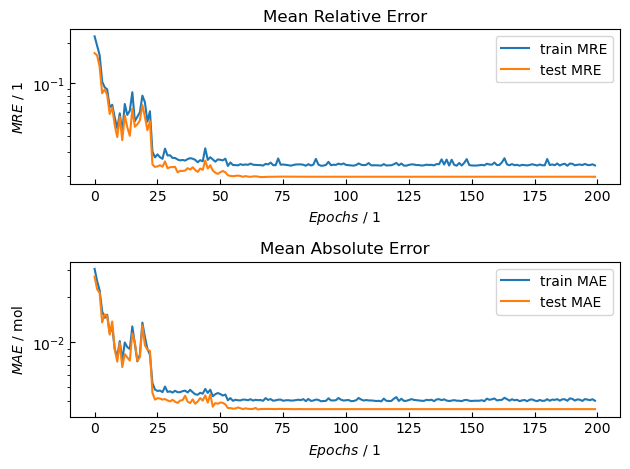

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

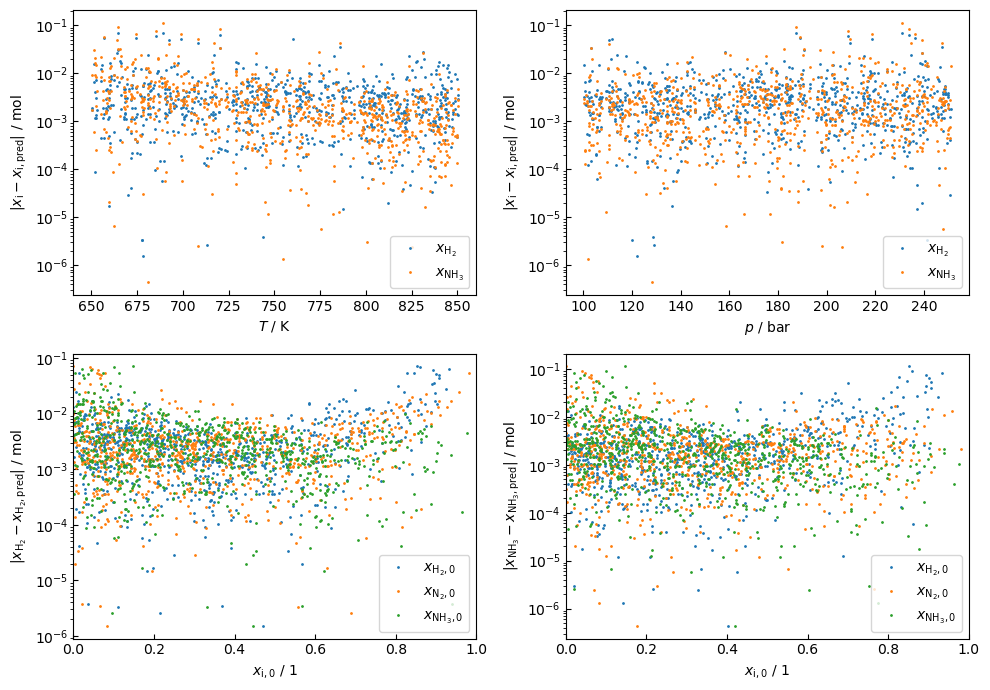

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

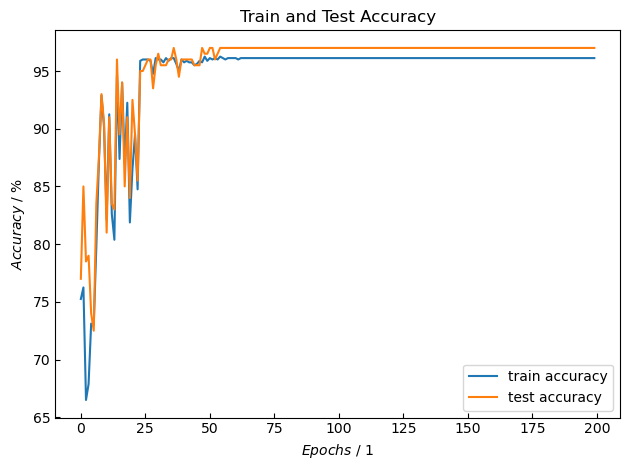

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.5370,  0.8201,  0.4321, -0.2713, -0.1468],
        [ 0.2071, -1.0022, -1.1003, -1.0869,  2.1908],
        [-0.1780, -1.2922, -0.9228, -0.1651,  1.0744],
        [-0.9413,  1.6363, -0.9039,  0.7035,  0.1681],
        [ 0.2721,  1.5879, -0.9495, -0.1168,  1.0512],
        [-0.1408,  1.5604,  0.4936,  0.7926, -1.2945],
        [-0.3623,  1.6103, -0.6810, -0.5935,  1.2749],
        [ 1.3626, -0.2621,  2.2885, -1.2217, -0.9972],
        [ 0.5493,  0.1114, -0.9674, -1.2566,  2.2338],
        [ 1.4611, -0.6289,  0.6150,  0.2164, -0.8247],
        [-0.4505, -1.5755,  0.2509, -1.0406,  0.8173],
        [ 1.3538, -0.2770,  0.4574,  0.3898, -0.8474],
        [-0.2842,  1.2936, -0.2899, -0.1385,  0.4261],
        [ 0.5004, -0.7904,  0.0680,  0.0222, -0.0894],
        [-0.8547,  0.0868, -1.3352,  0.2575,  1.0471],
        [-1.6077,  1.6608, -0.6660,  0.9604, -0.3280],
        [-1.4143,  0.0067,  0.1489,  0.7885, -0.9521],
        [-0.4671, -0.2839, -1.1062, -1.3442,  2.4594],
        [-

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 6.1808e-02,  5.7811e-02,  6.0973e-01, -6.8206e-02, -2.4160e-01],
         [-4.6564e-01, -1.7022e-01, -1.1849e-01, -3.5587e-02,  1.0686e-01],
         [ 3.2426e-01, -1.2895e-01, -7.2866e-02, -5.3507e-02, -2.7530e-01],
         [-4.2609e-01, -1.4441e-01, -2.8736e-01,  1.2915e-01,  2.1092e-01],
         [ 4.8176e-01, -1.4350e-01,  2.3752e-01,  2.8367e-01,  1.4514e-01],
         [-9.4427e-02,  1.1326e-02, -1.2841e-01,  2.4735e-01, -2.8242e-01],
         [-3.2097e-01, -2.0841e-02, -2.1483e-01,  2.0230e-01, -2.1956e-01],
         [ 4.4013e-02,  2.3357e-01, -3.9665e-01,  1.4253e-01, -6.5294e-02],
         [-7.8068e-02,  7.7243e-02,  7.1906e-02, -1.2274e-01,  1.7116e-01],
         [ 2.1398e-03, -1.3308e-01, -3.7482e-01,  2.9402e-01,  1.7847e-02],
         [-3.4931e-02,  2.8600e-02, -2.7354e-01,  2.3678e-01,  1.2220e-01],
         [ 2.8627e-01,  1.7197e-01, -1.3467e-01, -2.2741e-02, -1.1793e-01],
         [ 1.0073e-02,  4.9422e-02,  3.9433e-01,  2.7410e-01,  3.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8293, 0.7173, 0.2150, 0.4627, 0.6366],
        [0.5422, 0.9524, 0.5254, 0.7165, 0.9677]])
tensor([[ 0.1436, -0.5051],
        [ 0.0797, -0.3289]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-1.3485e-01, -1.1677e-01, -4.7333e-01, -2.0470e-01,  6.7373e-01],
        [ 1.6188e+00,  9.8707e-01,  4.7918e-02,  5.4363e-01, -6.0266e-01],
        [ 8.1721e-01,  9.3040e-01, -1.3870e+00, -1.3386e+00,  2.7294e+00],
        [-1.2618e+00, -1.5746e+00, -2.2816e-01,  1.3899e-01,  8.1845e-02],
        [-1.3192e+00,  1.5007e+00,  1.4919e-01, -1.1152e+00,  9.9342e-01],
        [-1.0688e+00, -6.8308e-01,  1.1443e+00, -1.0284e+00, -7.1911e-02],
        [ 1.4667e+00,  2.5792e-01, -8.7940e-01,  4.0229e-01,  4.5186e-01],
        [-1.1109e+00, -5.5717e-01, -1.2407e+00,  2.2930e+00, -1.1260e+00],
        [ 1.3765e+00, -8.7062e-04,  8.6525e-01, -1.3326e+00,  5.1291e-01],
        [-9.9977e-01, -2.5661e-01,  2.9742e-01, -1.2619e-01, -1.6291e-01],
        [-1.1458e+00,  1.7420e-01,  1.3031e+00,  8.9426e-02, -1.3702e+00],
        [-6.2913e-01, -1.6556e+00, -1.0616e+00, -9.6326e-01,  2.0264e+00],
        [-1.3782e+00,  9.6939e-02, -7.1425e-01,  6.9541e-01, -9.8083e-03],
        [-9.5278e-01, -1.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()